# Translation model from COCO -> MPII


In [38]:
import torch
import numpy as np
import torch.nn as nn
import copy
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import json

In [2]:
def describe(data):
  # Find maximum value
  max_val = np.max(data)

  # Find minimum value
  min_val = np.min(data)

  # Find 25th percentile
  percentile_25 = np.percentile(data, 25)

  # Find 75th percentile
  percentile_75 = np.percentile(data, 75)

  print("Maximum:", max_val)
  print("Minimum:", min_val)
  print("25th percentile:", percentile_25)
  print("75th percentile:", percentile_75)

In [3]:


ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/repos/scripts/data/mpii_train_gt.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/scripts/data/coco_pred_mpii.json', 'r') as f:
    annot_pred_coco = json.load(f)

# with open(ROOT_FOLDER + '/repos/scripts/mpii_pred_on_mpii/pred.json', 'r') as f:
#     annot_pred_mpii = json.load(f)



In [47]:
X = list()
y = list()
box_scale = list()
box_center = list()
index2orig = list()

print("len: " , len(annot_truth))
for i in range(len(annot_truth)):
  skip = False
  for joint_vis in annot_truth[i]['joints_vis']:
    if joint_vis == 0:
      skip = True
      break
  if skip:
    continue
  index2orig.append(i)
  X.append(annot_pred_coco['annotations'][i]['joints'])
  y.append(annot_truth[i]['joints'])
  box_scale.append(annot_truth[i]['scale'])
  box_center.append(annot_truth[i]['center'])
X = np.array(X)
y = np.array(y)
box_scale = np.array(box_scale)
box_center = np.array(box_center)
print("X shape: ", X.shape)
print("y shape:", y.shape)
print("box scale:", box_scale.shape)
print("box center:", box_center.shape)

len:  22246
X shape:  (14975, 17, 2)
y shape: (14975, 16, 2)
box scale: (14975,)
box center: (14975, 2)


## Normalize the dataset
- First by scale value of the bounding box
- Then either 0-1 normalization

Maximum: 142.49721067436224
Minimum: -127.8703812075263
25th percentile: -29.486130751675454
75th percentile: 18.7032727790721
Maximum: 182.44418701336446
Minimum: -414.840529399002
25th percentile: -23.56968379968597
75th percentile: 19.339848243111714


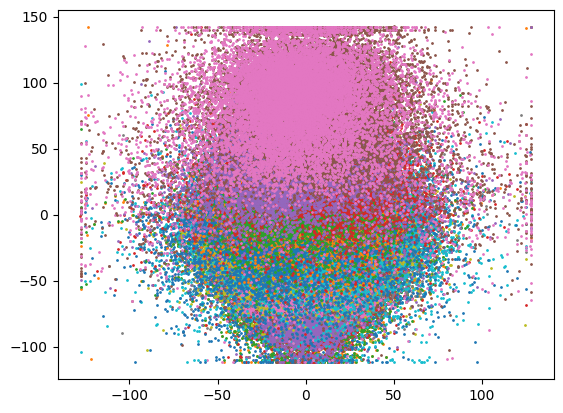

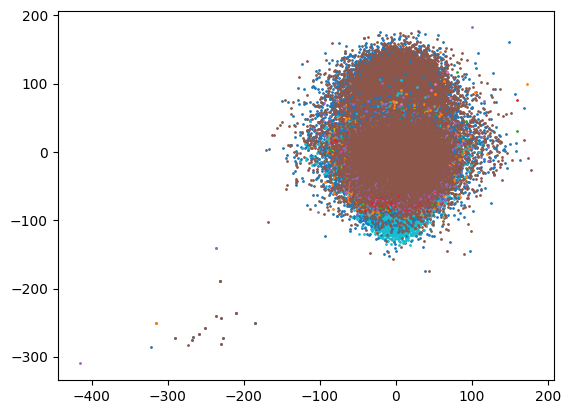

In [55]:

X_normalized = (X - np.repeat(box_center[:, np.newaxis, :], 17, axis=1)) / box_scale[:, np.newaxis, np.newaxis]
y_normalized = (y - np.repeat(box_center[:, np.newaxis, :], 16, axis=1)) / box_scale[:, np.newaxis, np.newaxis]
describe(X_normalized)
describe(y_normalized)
X_normalized.shape


for i in range(17):
  plt.scatter(X_normalized[:, i, 0],X_normalized[:, i, 1], s=1)
plt.show()

for i in range(16):
  plt.scatter(y_normalized[:, i, 0],y_normalized[:, i, 1], s=1)
plt.show()

# print(_normalized)
# Remove outliers, probably joint_vis = 0


### Display outliers in normalized env

In [92]:
outlier_index = np.argmin(y_normalized)
index = np.unravel_index(outlier_index, y_normalized.shape)
print(index)
print(y[ index[0] ])
print(y_normalized[index[0]])
print("Box center")
print(box_center[index[0]])
print("Box scale")
print(box_scale[index[0]])

print("Joint vis")

print(annot_truth[index2orig[index[0]]]['joints_vis'])
print(len(annot_truth[index2orig[index[0]]]['joints_vis']))


(9630, 14, 0)
[[1241.  533.]
 [1245.  490.]
 [1249.  424.]
 [1276.  420.]
 [1277.  488.]
 [1278.  532.]
 [1263.  422.]
 [1249.  354.]
 [1242.  333.]
 [1229.  297.]
 [1239.  404.]
 [1241.  377.]
 [1223.  365.]
 [1274.  343.]
 [ 736.   15.]
 [1276.  390.]]
[[  23.43241484  139.72662183]
 [  26.90388371  102.40833153]
 [  30.37535257   45.12909525]
 [  53.80776741   41.65762638]
 [  54.67563463  100.67259709]
 [  55.54350184  138.85875461]
 [  42.5254936    43.39336082]
 [  30.37535257  -15.62160989]
 [  24.30028206  -33.84682144]
 [  13.01800824  -65.09004122]
 [  21.69668041   27.77175092]
 [  23.43241484    4.33933608]
 [   7.81080495   -6.07507051]
 [  52.07203298  -25.16814927]
 [-414.8405294  -309.82859622]
 [  53.80776741   15.62160989]]
Box center
[1214.  372.]
Box scale
1.15225
Joint vis
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
16


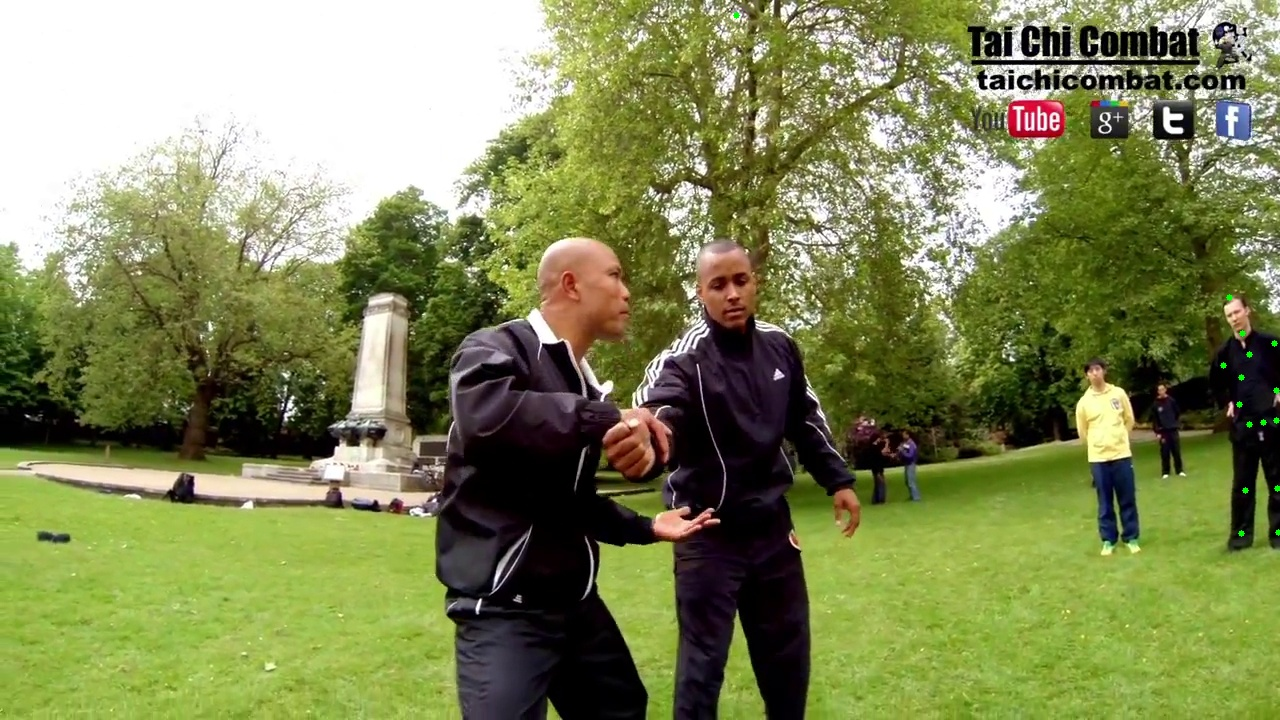

In [89]:
ROOT_FOLDER = "/datagrid/personal/baljibil"

# from utils import display_kp_image
from IPython.display import Image, display
import cv2

def display_kp_image(im_path, keypoints):

  image = cv2.imread(im_path)

  for kp in keypoints:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

  # Split the image horizontally
#   image1 = image[:, :image.shape[1]//2]
#   image2 = image[:, image.shape[1]//2:]

  # Display the annotated images side by side
  cv2.imwrite(f'tm_results/image_test0.jpg', image)

  display(Image(filename=f'tm_results/image_test0.jpg'))

display_kp_image(ROOT_FOLDER+'/data/MPII_COCO/images/'+annot_truth[index2orig[index[0]]]['image'],
                annot_truth[index2orig[index[0]]]['joints']
                 )

In [6]:
from sklearn.model_selection import train_test_split

## Split train, val, test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print("Train instance: ", X_train.shape[0])
print("Val instance: ", X_val.shape[0])
print("Test instance: ", X_test.shape[0])

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

Train instance:  7861
Val instance:  2621
Test instance:  4493
torch.Size([7861, 17, 2])
torch.Size([7861, 16, 2])
torch.Size([2621, 17, 2])
torch.Size([2621, 16, 2])


In [8]:
# Create a DataLoader for training and validation data
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset)

In [28]:
a = torch.rand((4,2))
print(a)
print(a.flatten())
print(a.view(4,2))

tensor([[0.1831, 0.5804],
        [0.5329, 0.1292],
        [0.2648, 0.5956],
        [0.9941, 0.0226]])
tensor([0.1831, 0.5804, 0.5329, 0.1292, 0.2648, 0.5956, 0.9941, 0.0226])
tensor([[0.1831, 0.5804],
        [0.5329, 0.1292],
        [0.2648, 0.5956],
        [0.9941, 0.0226]])


In [30]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TranslatorNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.hidden1 = nn.Linear(17 * 2, 32)
        self.act1 = nn.ReLU()
        self.output = nn.Linear(32, 16*2)
        # self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.act1(self.hidden1(x))
        x = self.output(x)
        return x.view(-1, 16, 2)

    
# Instantiate the model, loss function, and optimizer
model = TranslatorNN().to(device)
# print(X_train.shape)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 1
best_model = None
best_val_loss = 10000000
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_epoch_loss = val_loss / len(val_dataset)
    if val_loss < best_val_loss:
        best_model = copy.deepcopy(model)
        best_val_loss = val_loss
    if (epoch+1) % 10 == 1:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}")
print(model)



Epoch [1/1], Train Loss: 231.5396, Val Loss: 126.6300
TranslatorNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden1): Linear(in_features=34, out_features=32, bias=True)
  (act1): ReLU()
  (output): Linear(in_features=32, out_features=32, bias=True)
)


## Display some images from translation model

In [10]:
import cv2
from IPython.display import Image, display

18174 023081173.jpg
torch.Size([1, 17, 2])
keypoints:  torch.Size([1, 16, 2])
[[  632.9016     220.61682 ]
 [ 1243.5662      65.59803 ]
 [  -32.068382  -595.5118  ]
 [ 1412.1504    -487.0833  ]
 [ 2809.931     -187.97423 ]
 [ 3120.446     -427.1071  ]
 [  709.5812    -795.78625 ]
 [ 1319.1821    -816.9928  ]
 [ 1089.27       122.10983 ]
 [ 1162.7933   -1003.42255 ]
 [ -257.43124    308.40207 ]
 [-1010.8934     208.56827 ]
 [ -225.17041   -814.875   ]
 [ 1664.265     -771.77216 ]
 [ 2423.9216    -347.71417 ]
 [ 2802.0857    1146.1713  ]]
[[2199.90161133  633.61682129]
 [2810.56616211  478.59803009]
 [1534.93161774 -182.51177979]
 [2979.15039062  -74.08331299]
 [4376.9309082   225.02577209]
 [4687.44604492  -14.10708618]
 [2276.58117676 -382.78625488]
 [2886.18212891 -403.99279785]
 [2656.27001953  535.10983276]
 [2729.79333496 -590.42254639]
 [1309.5687561   721.40206909]
 [ 556.10662842  621.56826782]
 [1341.82958984 -401.875     ]
 [3231.26501465 -358.77215576]
 [3990.92163086   65.28

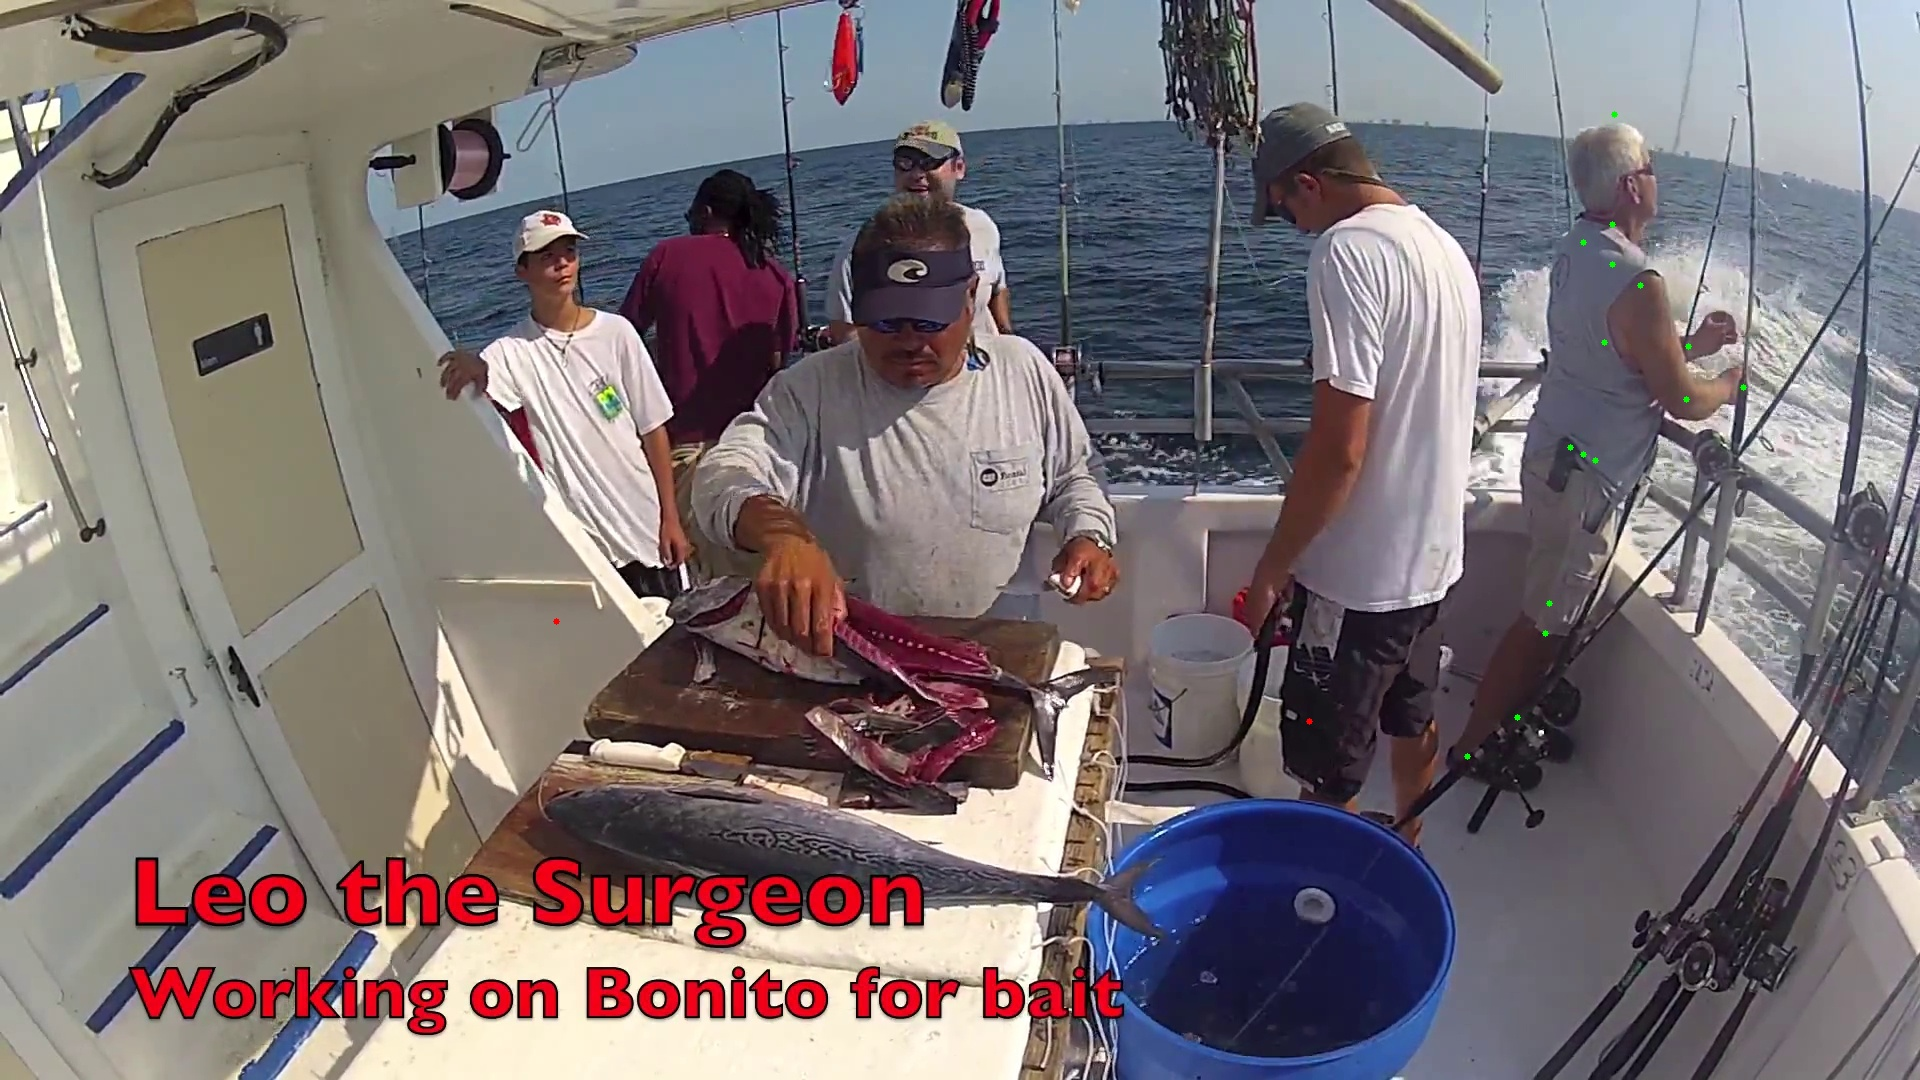

17948 042156176.jpg
torch.Size([1, 17, 2])
keypoints:  torch.Size([1, 16, 2])
[[ -87.19064    99.12831 ]
 [ 119.93425    84.33844 ]
 [ -41.612053 -112.18589 ]
 [ 219.45297   -43.903164]
 [ 414.65485    27.53546 ]
 [ 478.4188    -29.788755]
 [ 173.58577  -124.526306]
 [ 315.00378  -161.2225  ]
 [ 293.8467     22.910479]
 [ 358.26572  -269.2022  ]
 [ -72.60345  -131.4053  ]
 [-190.36357   -28.157282]
 [  -4.099535 -201.34834 ]
 [ 445.95605  -141.48979 ]
 [ 612.64307   -87.18007 ]
 [ 591.5061     85.88315 ]]
[[295.80935669 415.12831116]
 [502.93424988 400.33843994]
 [341.38794708 203.8141098 ]
 [602.45297241 272.09683609]
 [797.65484619 343.53545952]
 [861.41879272 286.21124458]
 [556.58576965 191.47369385]
 [698.00378418 154.77749634]
 [676.84671021 338.91047859]
 [741.26571655  46.79779053]
 [310.39655304 184.59469604]
 [192.63642883 287.84271812]
 [378.90046501 114.6516571 ]
 [828.95605469 174.51020813]
 [995.64306641 228.81993103]
 [974.50610352 401.88314819]]
(16, 2)


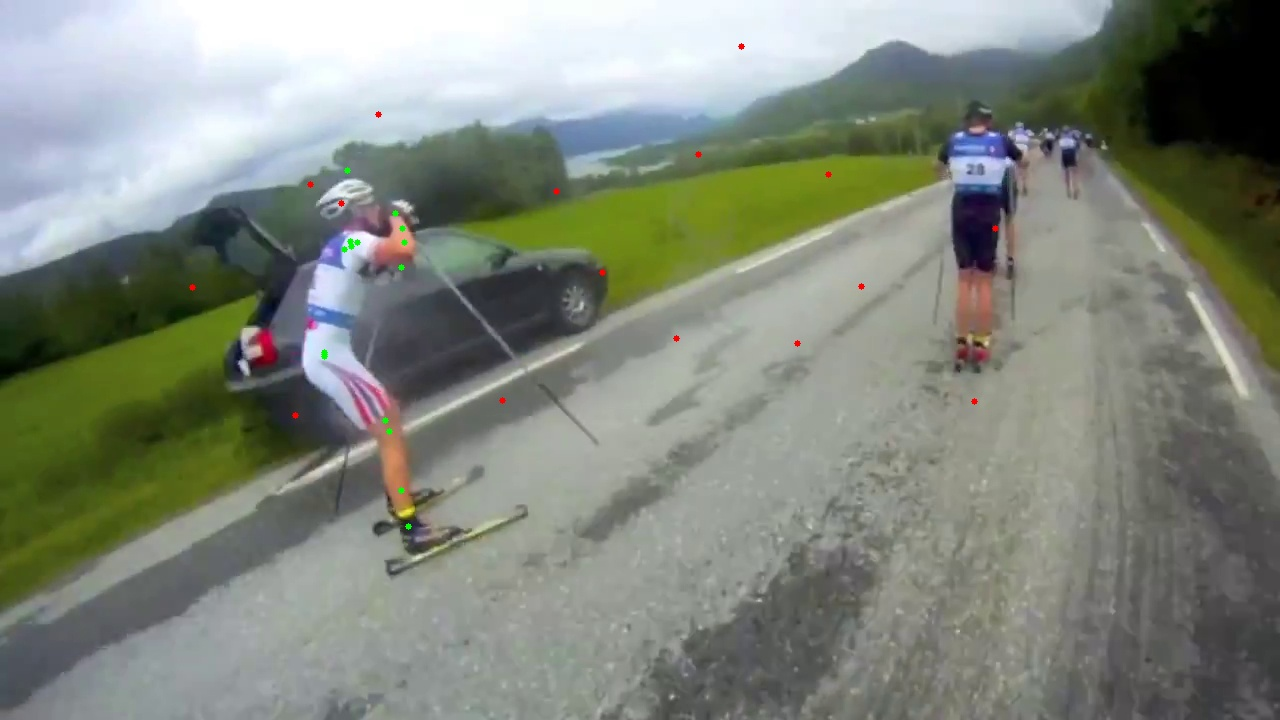

2325 045799576.jpg
torch.Size([1, 17, 2])
keypoints:  torch.Size([1, 16, 2])
[[  51.19974    19.032629]
 [ 149.38861    18.241096]
 [  -8.333671  -87.42064 ]
 [ 175.82584   -44.127804]
 [ 355.94434   -12.657361]
 [ 407.88818   -60.682972]
 [ 120.318756  -99.36568 ]
 [ 175.8957    -97.10489 ]
 [ 165.0156     36.859493]
 [ 178.8908   -131.7506  ]
 [ -51.83371   -17.79187 ]
 [-144.31378    19.817896]
 [ -35.586212 -107.649796]
 [ 252.4768    -84.14679 ]
 [ 362.1926    -45.913586]
 [ 388.6845    128.64548 ]]
[[596.19974136 268.03262901]
 [694.38861084 267.2410965 ]
 [536.66632938 161.57936096]
 [720.82583618 204.8721962 ]
 [900.94433594 236.34263897]
 [952.88818359 188.31702805]
 [665.3187561  149.63432312]
 [720.89570618 151.89511108]
 [710.01559448 285.85949326]
 [723.89079285 117.24940491]
 [493.16629028 231.20812988]
 [400.68621826 268.81789589]
 [509.41378784 141.35020447]
 [797.47680664 164.85321045]
 [907.19259644 203.08641434]
 [933.68450928 377.64547729]]
(16, 2)


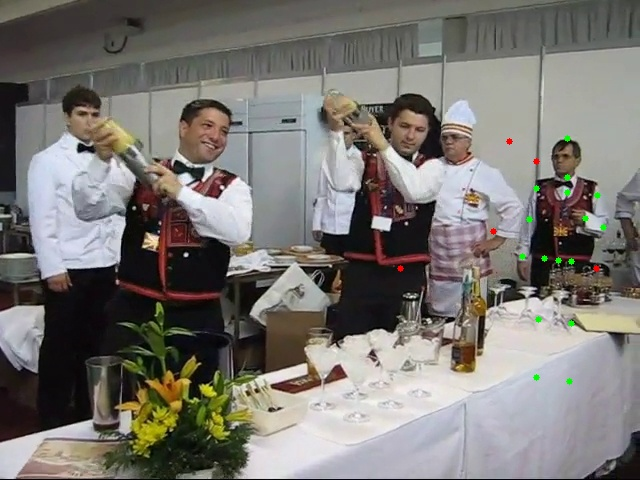

1637 024667886.jpg
torch.Size([1, 17, 2])
keypoints:  torch.Size([1, 16, 2])
[[  422.21936    930.1229  ]
 [ 1907.9336     682.19995 ]
 [ -167.3325   -1123.9325  ]
 [ 2995.4958    -527.22217 ]
 [ 5401.922       63.215286]
 [ 6259.087     -327.56516 ]
 [ 1927.248    -1334.085   ]
 [ 2956.7937   -1788.8167  ]
 [ 2543.3486     113.25917 ]
 [ 2794.925    -2610.6428  ]
 [-1082.8523      68.08649 ]
 [-2471.975      206.43692 ]
 [ -544.21857  -1939.7477  ]
 [ 4253.4644   -1734.86    ]
 [ 5930.8496    -719.1894  ]
 [ 6273.1606    2058.5374  ]]
[[ 2105.21936035  1517.1229248 ]
 [ 3590.93359375  1269.19995117]
 [ 1515.66749573  -536.93249512]
 [ 4678.49584961    59.77783203]
 [ 7084.921875     650.21528625]
 [ 7942.08691406   259.43484497]
 [ 3610.24804688  -747.08496094]
 [ 4639.79370117 -1201.81665039]
 [ 4226.34863281   700.25917053]
 [ 4477.92504883 -2023.64282227]
 [  600.14770508   655.08648682]
 [ -788.97509766   793.43692017]
 [ 1138.78143311 -1352.74768066]
 [ 5936.46435547 -1147.859985

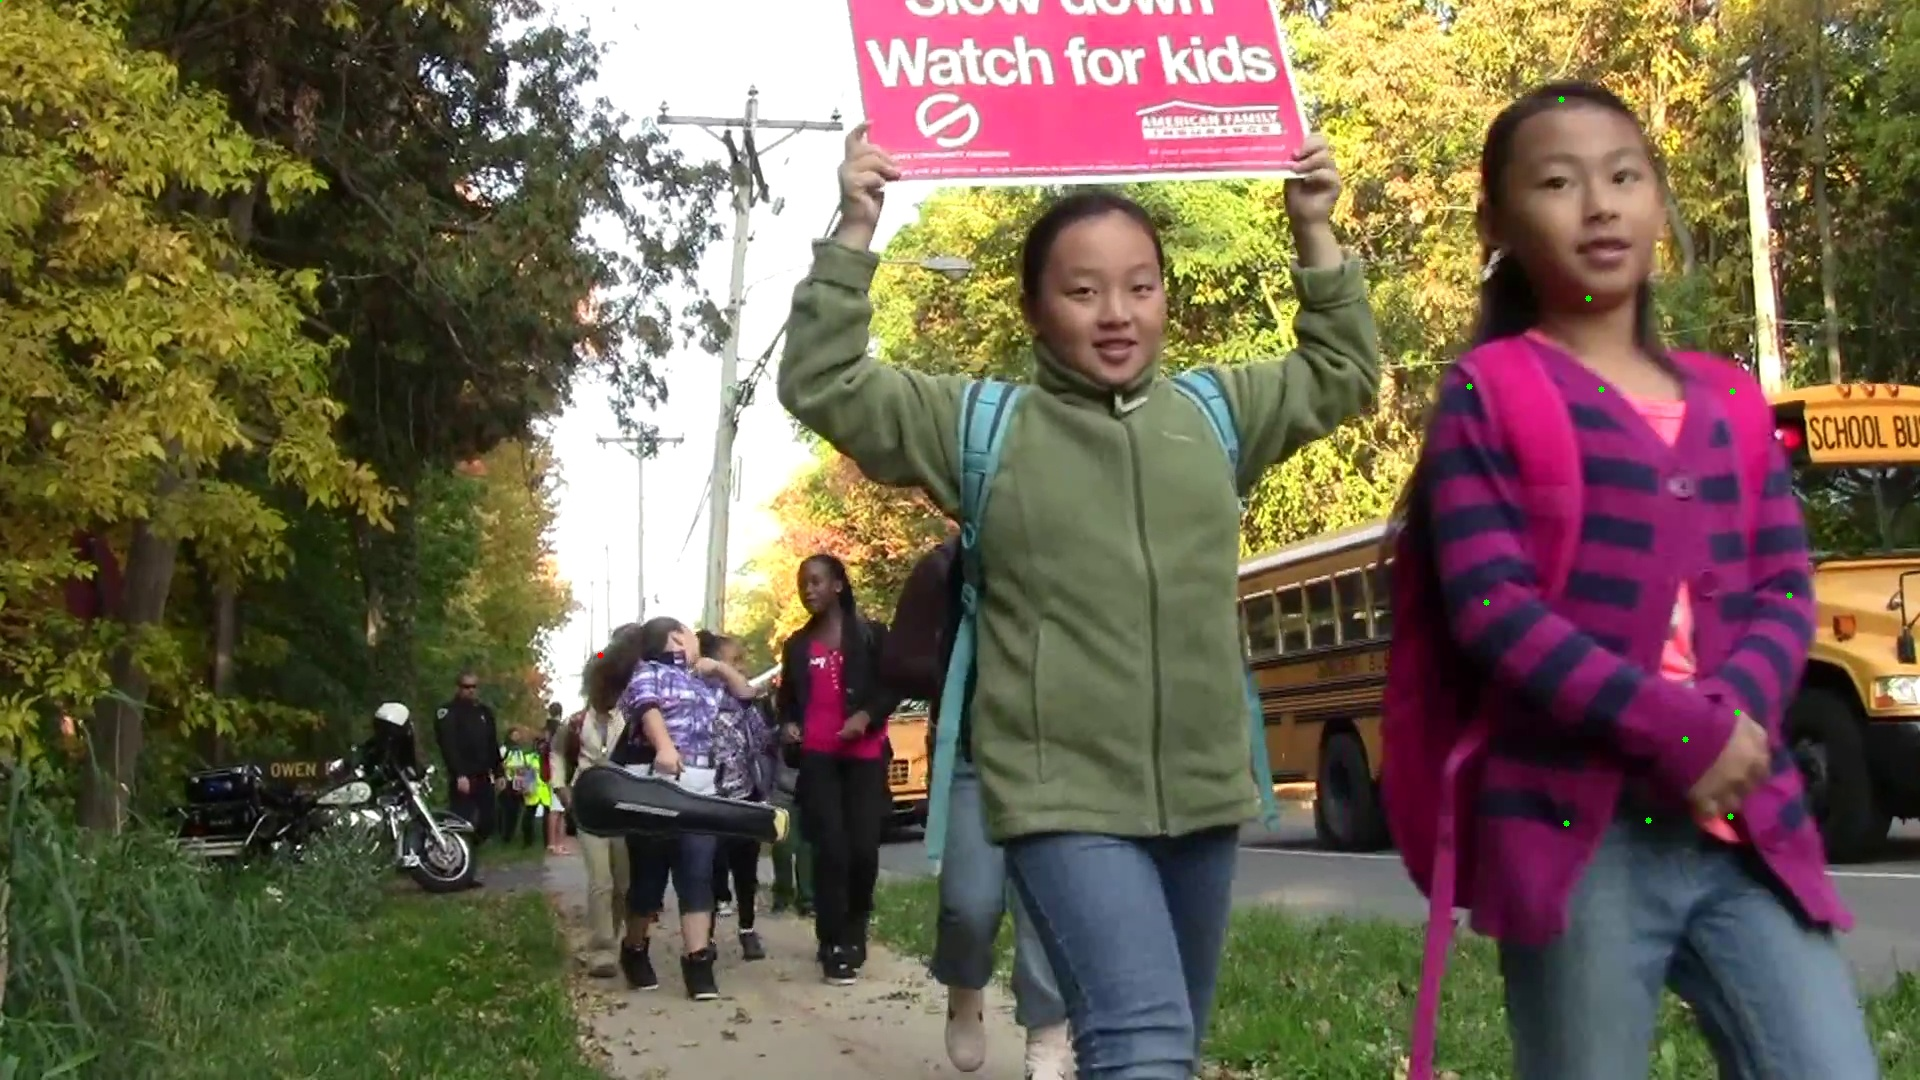

2441 037172407.jpg
torch.Size([1, 17, 2])
keypoints:  torch.Size([1, 16, 2])
[[ 273.68298    -41.68933  ]
 [ 640.0822      -3.0571234]
 [ -35.658916  -375.76477  ]
 [ 639.7658    -181.7756   ]
 [1417.5457    -106.80894  ]
 [1641.1028    -349.2251   ]
 [ 444.44287   -409.93982  ]
 [ 619.3104    -314.8902   ]
 [ 627.90894    239.10487  ]
 [ 664.9861    -416.83765  ]
 [-155.20886   -129.22252  ]
 [-547.24475    116.8538   ]
 [-170.01535   -354.45135  ]
 [ 910.8487    -263.12445  ]
 [1348.4724    -190.44612  ]
 [1507.4747     495.80508  ]]
[[1417.6829834   500.31066895]
 [1784.08221436  538.94287658]
 [1108.34108353  166.23522949]
 [1783.76580811  360.22439575]
 [2561.5456543   435.19106293]
 [2785.1027832   192.77490234]
 [1588.44287109  132.06018066]
 [1763.3104248   227.10980225]
 [1771.90893555  781.10487366]
 [1808.98608398  125.16235352]
 [ 988.7911377   412.77748108]
 [ 596.75524902  658.85379791]
 [ 973.98464966  187.54864502]
 [2054.84869385  278.87554932]
 [2492.47241211  351.553

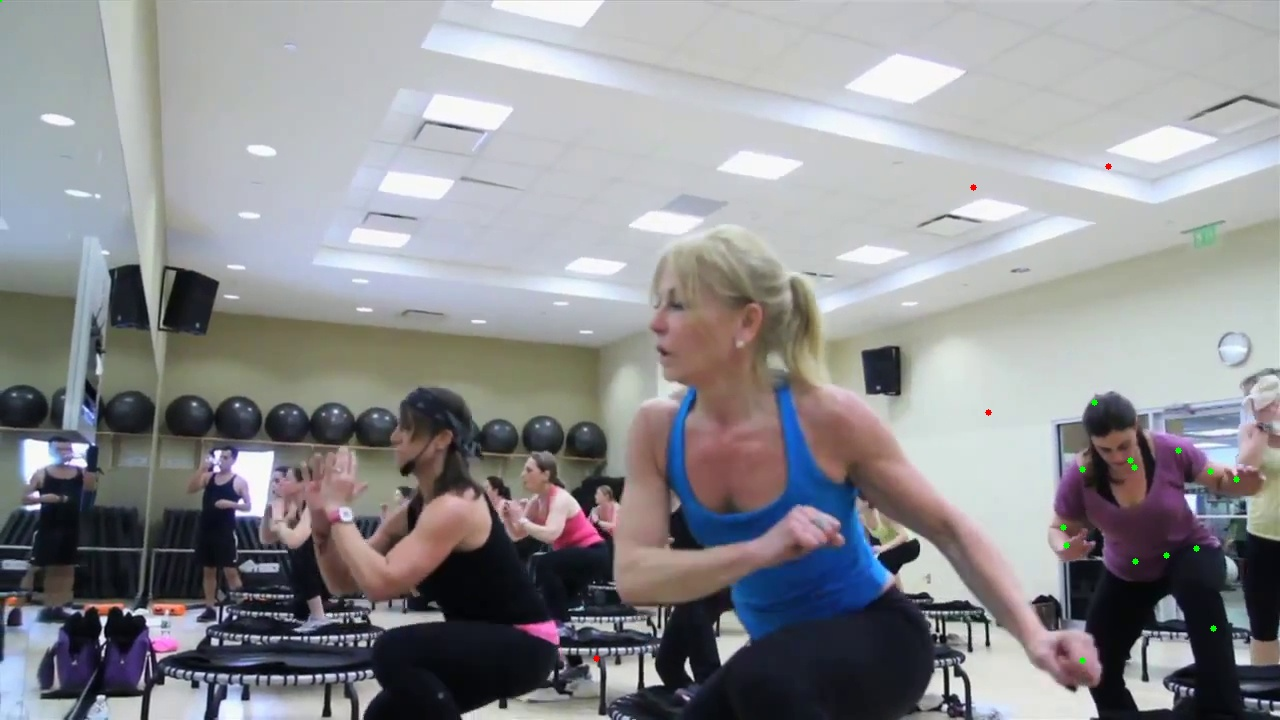

4181 005574085.jpg
torch.Size([1, 17, 2])
keypoints:  torch.Size([1, 16, 2])
[[-1104.4656      51.157833]
 [ -547.85944     50.963524]
 [ -166.0663     -49.362133]
 [  134.84892     10.873837]
 [ -100.986176    40.128616]
 [ -408.80618    -85.62186 ]
 [   -3.705714   -75.30839 ]
 [  495.1031     -64.752975]
 [  468.02432    -45.725544]
 [  737.10986   -221.67877 ]
 [   -9.344391    -6.743523]
 [  -21.83147   -103.698494]
 [  238.97374   -155.81161 ]
 [  682.1871     -40.531097]
 [  729.6839     135.67136 ]
 [  593.4782     333.05075 ]]
[[-976.46557617  600.1578331 ]
 [-419.85943604  599.96352386]
 [ -38.06629944  499.63786697]
 [ 262.84892273  559.87383747]
 [  27.01382446  589.12861633]
 [-280.80618286  463.37814331]
 [ 124.29428601  473.69161224]
 [ 623.10308838  484.24702454]
 [ 596.02432251  503.27445602]
 [ 865.10986328  327.32122803]
 [ 118.65560913  542.25647688]
 [ 106.16852951  445.30150604]
 [ 366.97373962  393.18838501]
 [ 810.18707275  508.46890259]
 [ 857.68389893  684.671

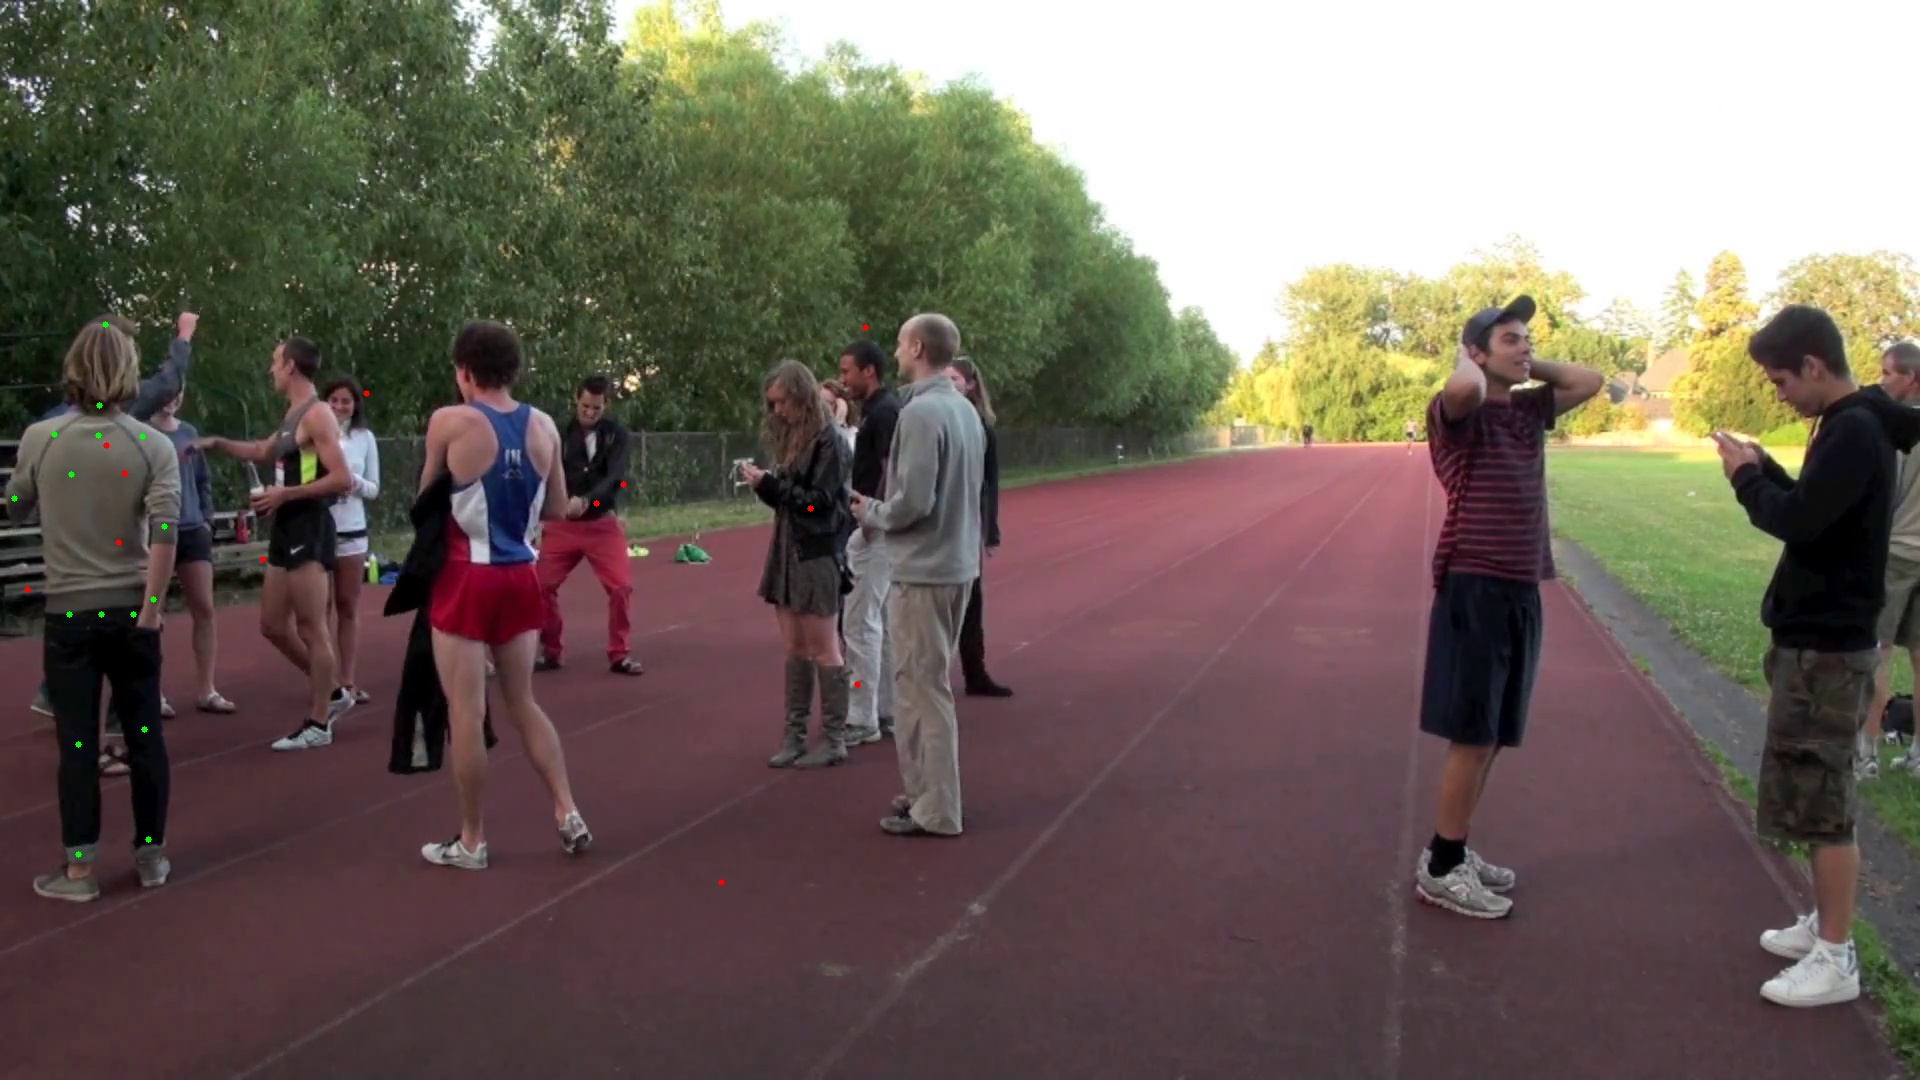

19074 001943267.jpg
torch.Size([1, 17, 2])
keypoints:  torch.Size([1, 16, 2])
[[-2079.6174    705.39636]
 [ -570.861     592.225  ]
 [ -139.66988  -244.8245 ]
 [ 1202.6664    -49.45304]
 [  945.713     421.5748 ]
 [  479.60583   233.6946 ]
 [  758.3388   -438.7051 ]
 [ 2069.7966   -655.9047 ]
 [ 1829.4374   -215.96313]
 [ 2483.7393  -1257.5621 ]
 [ -582.981    -362.09055]
 [ -573.44916  -476.32993]
 [  646.41486  -977.96545]
 [ 2757.3696   -450.4923 ]
 [ 3183.5261     71.09621]
 [ 2493.4885    970.1448 ]]
[[-1729.61743164  1288.3963623 ]
 [ -220.86102295  1175.22497559]
 [  210.3301239    338.17550659]
 [ 1552.66638184   533.54695892]
 [ 1295.7130127   1004.57479858]
 [  829.60583496   816.69459534]
 [ 1108.33880615   144.29489136]
 [ 2419.79663086   -72.90472412]
 [ 2179.43737793   367.03686523]
 [ 2833.73925781  -674.56213379]
 [ -232.98101807   220.90945435]
 [ -223.44915771   106.67007446]
 [  996.41485596  -394.9654541 ]
 [ 3107.36962891   132.50769043]
 [ 3533.52612305   654.0962

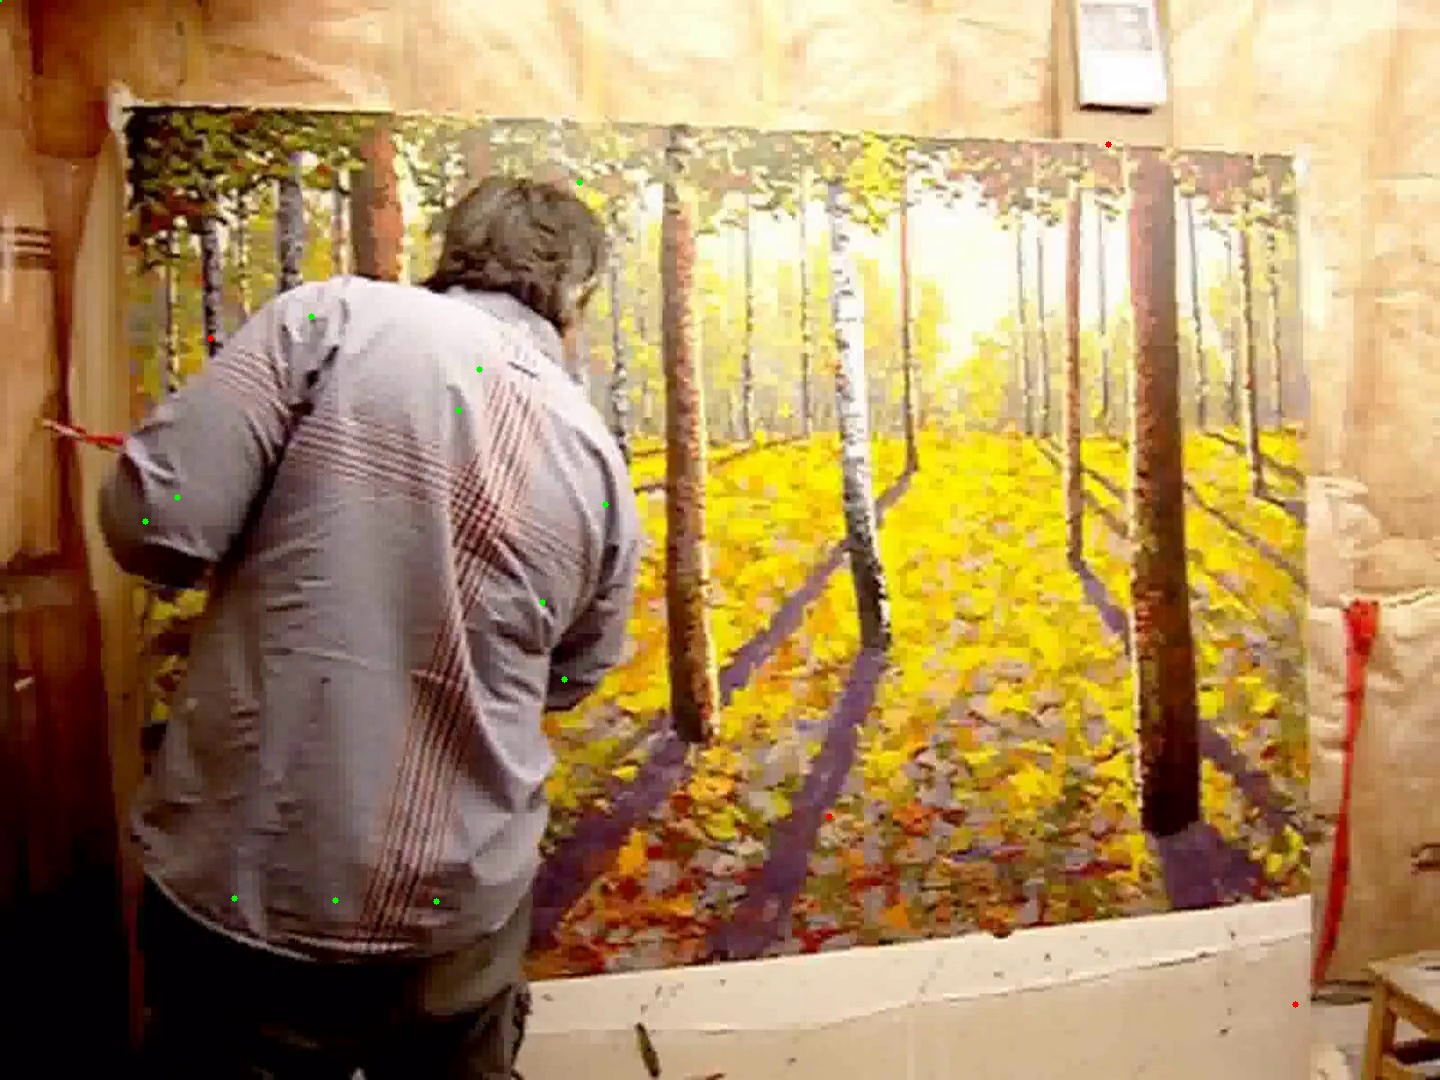

13087 091551673.jpg
torch.Size([1, 17, 2])
keypoints:  torch.Size([1, 16, 2])
[[-834.35535  407.23788]
 [-246.87175  312.78906]
 [-183.0318  -161.76776]
 [ 623.2168   -77.06159]
 [ 749.0899   195.81413]
 [ 661.7329   171.8129 ]
 [ 371.9659  -264.2027 ]
 [ 816.6298  -480.06946]
 [ 756.19556 -265.11392]
 [1043.1128  -855.71375]
 [-461.59055 -231.16129]
 [-578.96234 -259.84302]
 [  21.33776 -626.1532 ]
 [1340.8032  -425.93185]
 [1701.7008  -140.6007 ]
 [1438.5337   333.63223]]
[[-470.35534668  848.23788452]
 [ 117.12825012  753.7890625 ]
 [ 180.96820068  279.23223877]
 [ 987.21679688  363.9384079 ]
 [1113.08990479  636.81413269]
 [1025.73291016  612.81289673]
 [ 735.96591187  176.79730225]
 [1180.62982178  -39.06945801]
 [1120.19555664  175.88607788]
 [1407.11279297 -414.71374512]
 [ -97.59054565  209.8387146 ]
 [-214.96234131  181.15698242]
 [ 385.33776093 -185.15319824]
 [1704.80322266   15.06814575]
 [2065.70080566  300.39930725]
 [1802.53369141  774.63223267]]
(16, 2)


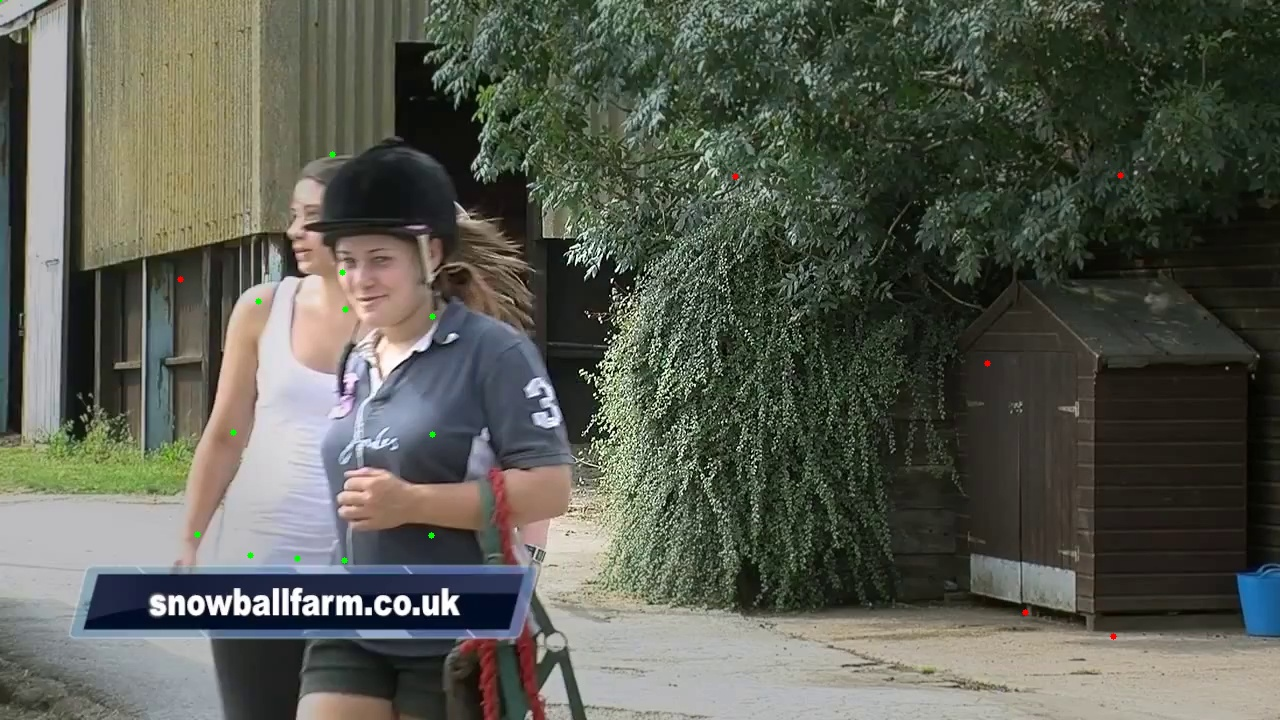

5211 025822681.jpg
torch.Size([1, 17, 2])
keypoints:  torch.Size([1, 16, 2])
[[ -678.8322    1209.491   ]
 [  641.7681     950.2296  ]
 [  -63.506664  -448.8103  ]
 [ 1975.9603    -140.50003 ]
 [ 2778.6956     424.63147 ]
 [ 3177.9978     420.83014 ]
 [ 1391.5942    -638.1778  ]
 [ 2520.6108   -1319.6139  ]
 [ 2093.762     -197.68881 ]
 [ 2475.2856   -2102.8164  ]
 [ -696.57886   -415.0137  ]
 [-1330.749     -230.17065 ]
 [  132.18828  -1525.548   ]
 [ 3394.23     -1179.8136  ]
 [ 4389.232     -412.36182 ]
 [ 4048.9465    1006.1672  ]]
[[  419.16778564  1611.4909668 ]
 [ 1739.76812744  1352.22961426]
 [ 1034.49333572   -46.81030273]
 [ 3073.96032715   261.49996948]
 [ 3876.69555664   826.63146973]
 [ 4275.99780273   822.83013916]
 [ 2489.59423828  -236.17779541]
 [ 3618.61083984  -917.6138916 ]
 [ 3191.76196289   204.31118774]
 [ 3573.28564453 -1700.81640625]
 [  401.42114258   -13.01370239]
 [ -232.74902344   171.8293457 ]
 [ 1230.1882782  -1123.54797363]
 [ 4492.22998047  -777.813598

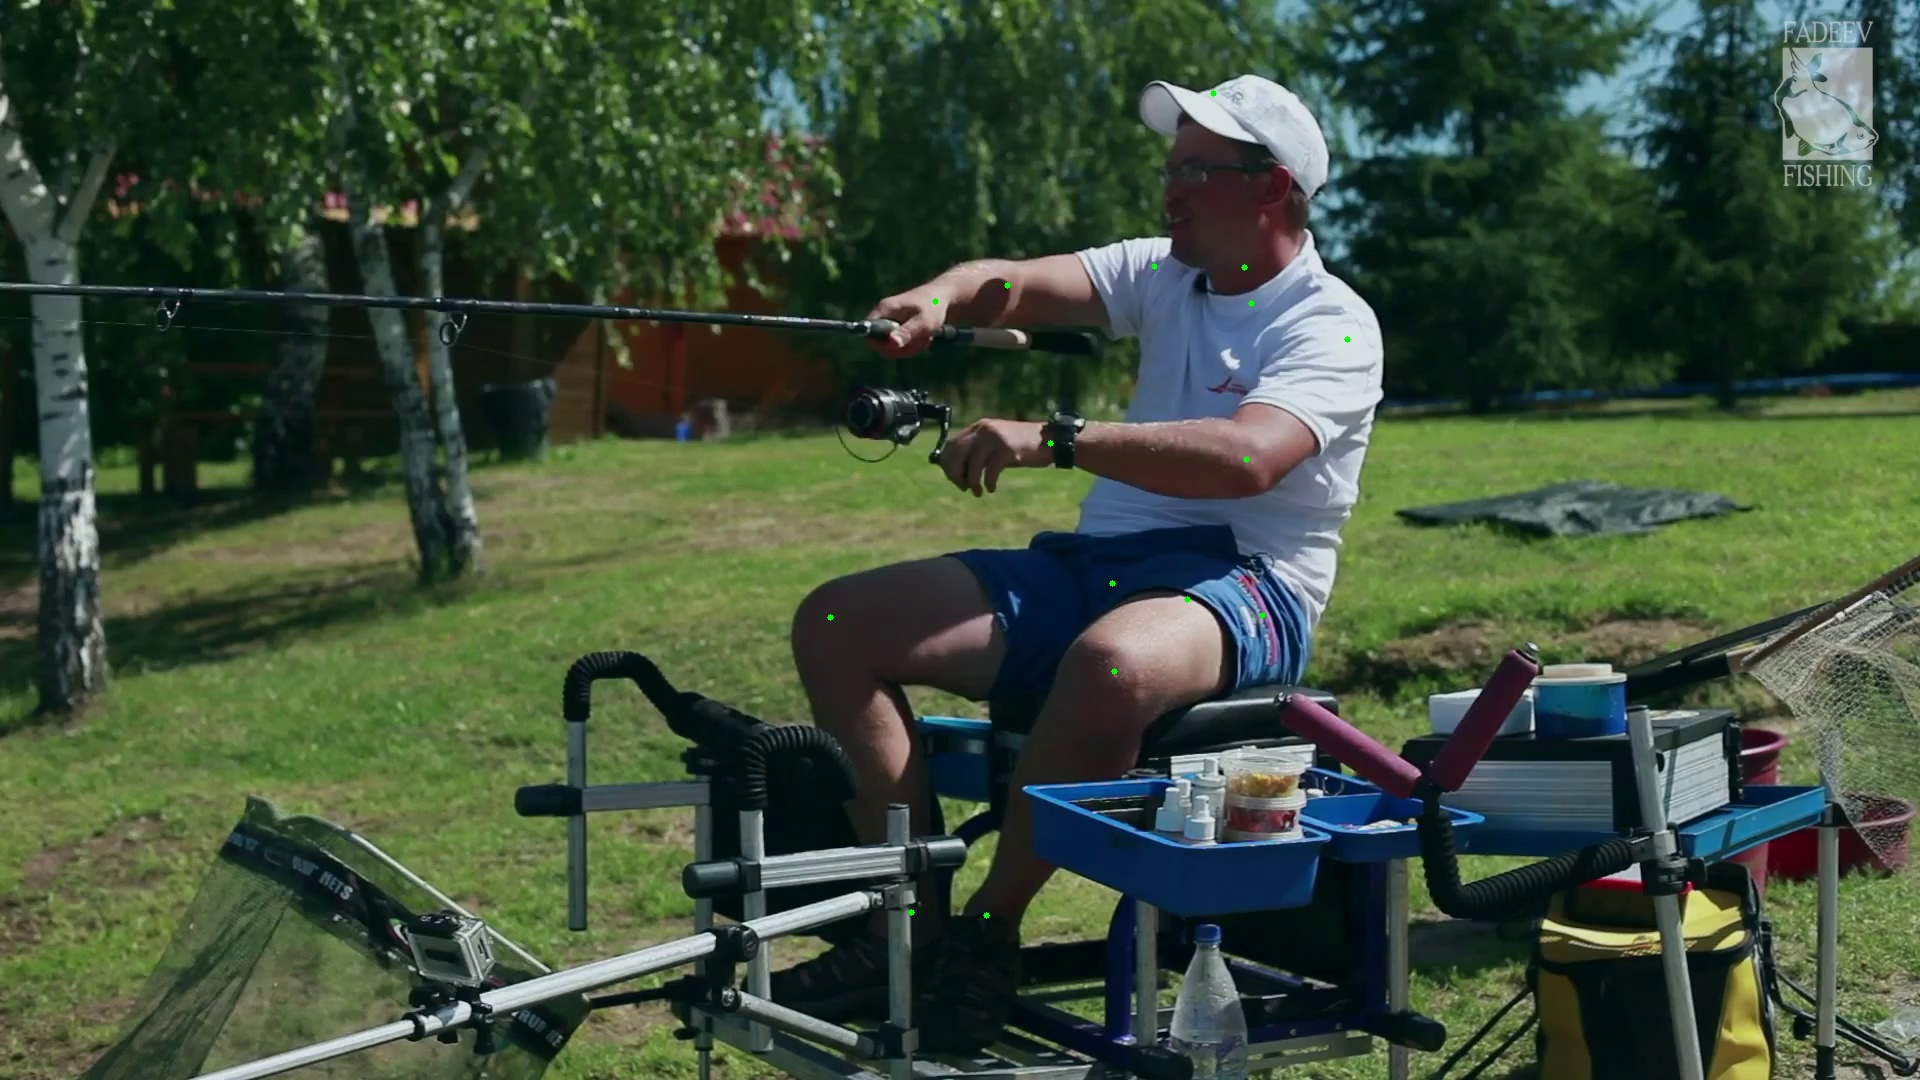

1025 044590271.jpg
torch.Size([1, 17, 2])
keypoints:  torch.Size([1, 16, 2])
[[-769.4394    341.13162 ]
 [  29.696888  286.95142 ]
 [ -94.00613  -248.31796 ]
 [ 684.41113  -128.24403 ]
 [ 923.717     137.74223 ]
 [ 836.0675    -13.663313]
 [ 466.63422  -348.4284  ]
 [1134.4713   -452.14383 ]
 [ 998.85046   -37.07348 ]
 [1300.9434   -794.4324  ]
 [-225.69223  -238.60368 ]
 [-406.35657  -168.66107 ]
 [ 226.04118  -606.4815  ]
 [1473.3009   -349.2899  ]
 [1872.6962    -75.257385]
 [1620.3844    469.90912 ]]
[[-121.43939209  753.13162231]
 [ 677.69688797  698.95141602]
 [ 553.9938736   163.68203735]
 [1332.41113281  283.75596619]
 [1571.71697998  549.74223328]
 [1484.06750488  398.33668709]
 [1114.63421631   63.57159424]
 [1782.47131348  -40.14382935]
 [1646.85046387  374.9265213 ]
 [1948.94335938 -382.43237305]
 [ 422.30776978  173.39631653]
 [ 241.64343262  243.33892822]
 [ 874.04118347 -194.48150635]
 [2121.30090332   62.71011353]
 [2520.69616699  336.74261475]
 [2268.38439941  881.9091

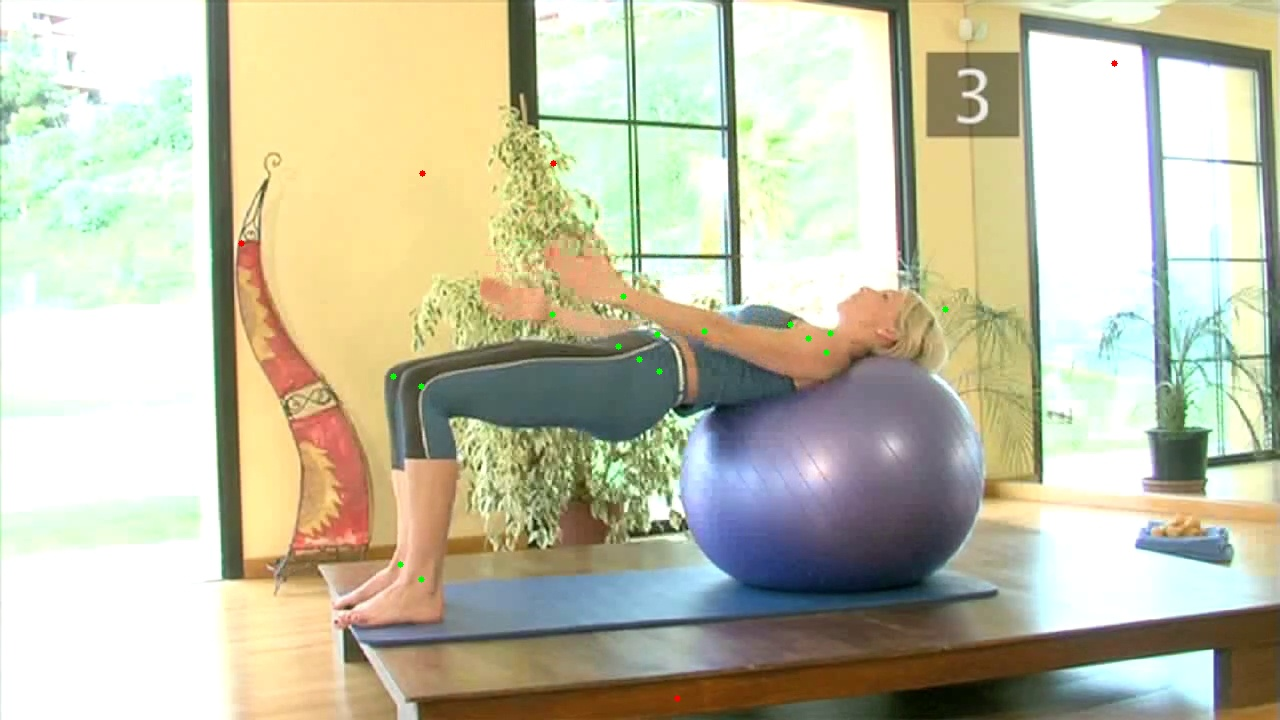

In [17]:

ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/data/MPII_COCO/annotations/mpii_train.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/scripts/data/coco_pred_mpii.json', 'r') as f:
    annot_pred_coco = json.load(f)


NUM_IMAGES = 1

# choose image from ground truth
def choose_n_images(gt_json):
  random_numbers = np.random.randint(0, len(gt_json), size=10)
  images = list()
  for nums in random_numbers:
     images.append((nums,gt_json[nums]['image']))
  return images

for index, im_path in choose_n_images(annot_truth):
  print(index, im_path)
  # Load the image
  image = cv2.imread(ROOT_FOLDER + '/data/MPII_COCO/images/' + im_path)

  # Load annotation keypoints from JSON files

  keypoints1 = annot_truth[index]['joints']
  # pred
  points = annot_pred_coco['annotations'][index]['joints']
  points = torch.tensor(points)
  points = points.unsqueeze(0)
  keypoints2 = None
  print(points.shape)
  model.eval()
  with torch.no_grad():
    points = points.to(device)
    keypoints2 = model(points)
  print('keypoints: ', keypoints2.shape)
  keypoints2 = keypoints2.squeeze()
  keypoints2 = keypoints2.to('cpu')
  keypoints2 = np.array(keypoints2)
  keypoints2 = annot_truth[index]['scale'] * keypoints2
  print(keypoints2)
  keypoints2 = keypoints2 + np.array(annot_truth[index]['center'])
  print(keypoints2)

  print(keypoints2.shape)
  # Draw keypoints on the image
  for kp in keypoints1:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

  for kp in keypoints2:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 0, 255), -1)

  # Resize the image if necessary
  # This step is optional, depending on your images

  # Split the image horizontally
#   image1 = image[:, :image.shape[1]//2]
#   image2 = image[:, image.shape[1]//2:]

  # Display the annotated images side by side
  cv2.imwrite(f'tm_results/image{i}.jpg', image)

  display(Image(filename=f'tm_results/image{i}.jpg'))


# Try building simple regressors

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print("Train instance: ", X_train.shape[0])
print("Val instance: ", X_val.shape[0])
print("Test instance: ", X_test.shape[0])

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)


Train instance:  7861
Val instance:  2621
Test instance:  4493
torch.Size([7861, 17, 2])
torch.Size([7861, 16, 2])
torch.Size([2621, 17, 2])
torch.Size([2621, 16, 2])


In [13]:
from sklearn import linear_model

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

X_train_stacked = np.reshape(X_train, (X_train.shape[0], -1))
print(X_train_stacked.shape)
X_val_stacked = np.reshape(X_val, (X_val.shape[0], -1))
print(X_val_stacked.shape)
print('y_val: ', y_val.shape)

for point in range(16):
  y_train_point = y_train[:, point]
  clf_x = linear_model.LinearRegression()
  clf_y = linear_model.LinearRegression()

  clf_x.fit(X_train_stacked, y_train_point[:, 0])
  clf_y.fit(X_train_stacked, y_train_point[:, 1])

  prediction_x = clf_x.predict(X_val_stacked)
  prediction_y = clf_y.predict(X_val_stacked)

  pred = np.stack((prediction_x, prediction_y), axis=1)
  error = ((pred - y_val[:, point]) ** 2).mean(axis = 1)
  # print(error[:10])
  error = np.mean(error)
  print(f'Error {point}: {error}')

    

(7861, 34)
(2621, 34)
y_val:  (2621, 16, 2)
Error 0: 224.21932983398438
Error 1: 94.02581024169922
Error 2: 57.048316955566406
Error 3: 58.99836730957031
Error 4: 89.52011108398438
Error 5: 235.37953186035156
Error 6: 46.26677322387695
Error 7: 25.42369842529297
Error 8: 27.508214950561523
Error 9: 55.37346267700195
Error 10: 188.04627990722656
Error 11: 76.92213439941406
Error 12: 42.63243103027344
Error 13: 43.588462829589844
Error 14: 81.3226089477539
Error 15: 133.448974609375


In [14]:
X_val = np.array(X_val)
y_val = np.array(y_val)
print(X_val.shape)
print(y_val.shape)

(2621, 17, 2)
(2621, 16, 2)


In [16]:
print((abs(X_val[:, 16] - y_val[:, 0])).mean(axis=0))
print((abs(X_val[:, 14] - y_val[:, 1])).mean(axis=0))
# Around head location
print((abs(X_val[:, 0] - y_val[:, 9])).mean(axis=0))

# print((abs(X_val[:, 16] - y_val[:, 0])).mean(axis=0))
# print((abs(X_val[:, 16] - y_val[:, 0])).mean(axis=0))
# print((abs(X_val[:, 16] - y_val[:, 0])).mean(axis=0))


[5.7771764 6.6435676]
[4.1824436 5.1991277]
[ 6.9651403 18.852098 ]
